# Inception Resnet Model
## Skeleton of final model submissions with variable parameters and settings
Top 3 accuracy: 86+%. 

In our earlier post, we focused on preprocessing and augmentation.
This was useful since we have a really challenging problem: 
- A lot of classes
- Misclassified training examples
- Not a lot of training examples per class. Roughly 300-600 per class.
- Variations in each image. Not all standard in lighting, centering, dimensions
- High-dimensional. How far can we reduce our data before we lose info? 

First thing we need to do is definitely do some data augmentation. We can do, say 25 classes to start on only 1/10 of the data available to us and we will augment away and see how that works. 

With that data agumentation we'll want to use a baseline method like a simple neural net or even a simple convnet to decide how effective our methods are.

Preprocessing on the input image that is automated (rather than hard-cut squaring) would allow us to pass through images of odd size. Something to think about. 

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #pick a GPU to use if using GPUs
import res

Using TensorFlow backend.


In [3]:
from matplotlib import cm

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
# from scipy.misc import imresize
import matplotlib.image as mpimg
%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input

In [5]:
# Ignore  the warnings
import warnings
# warnings.filterwarnings('always')
# warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle
import sklearn as sklearn

In [6]:
import tensorflow as tf


In [7]:
from keras.applications import ResNet50, inception_resnet_v2, inception_v3, resnet, resnet_v2
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [11]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Dropout, GaussianNoise, Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD, adam
from keras.regularizers import l2
import keras.backend as K
import math

K.clear_session()


## Useful Tools for the Problem
Includes things like: 
- One-hot encoding
- Matching up classes to indexes
- Functions for preprocessing and reverting to unprocessed data for visualization

Map class to index and vice versa so we can understand what we're predicting right/wrong.

In [9]:
class_to_ix = {}
ix_to_class = {}
with open('input/class_list.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

FileNotFoundError: [Errno 2] No such file or directory: 'input/class_list.txt'

One-hot encoding the training labels (output a list of binary features)

-------

Image augmentation is going to have to be looked at later. copy paste method of someone elses code isn't working

## Some GPU things

In [326]:
import tensorflow as tf
_LOCAL_DEVICES = tf.config.experimental.list_logical_devices()

In [327]:
import multiprocessing as mp

num_processes = 4
pool = mp.Pool(processes=num_processes)

Process ForkPoolWorker-90:
Process ForkPoolWorker-88:
Process ForkPoolWorker-91:
Process ForkPoolWorker-89:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/pyth

## Grab the data, format it in a way that we can process 

In [328]:
train_dir = 'input/train_set/'

val_dir = 'input/val_set/'
train_df = pd.read_csv('/home/reallsx/mlproj/input/train_labels_cleaned.csv')
train_df['path'] = train_df['img_name'].map(lambda x: os.path.join(train_dir,x))
val_df = pd.read_csv('./input/val_labels.csv')
val_df['path'] = val_df['img_name'].map(lambda x: os.path.join(val_dir,x))
val_df['label'] = val_df['label'].astype(str)
train_df['label'] = train_df['label'].astype(str)

## Some image functions for quick plots (final ones were made differently but this can give you an idea.) 

In [11]:
def reverse_preprocess_input(x):
    x *= 255.
    return x

In [12]:
%%time
@interact()
def show_images(unprocess=False):
    for x in cropped:# train_generator:
        fig, axes = plt.subplots(nrows=8, ncols=4)
        fig.set_size_inches(8, 8)
        page = 0
        page_size = 32
        start_i = page * page_size
        for i, ax in enumerate(axes.flat):
            img = x[0][i+start_i]
            if unprocess:
                im = ax.imshow( reverse_preprocess_input(img).astype('uint8') )
            else:
                im = ax.imshow(img)
            ax.set_axis_off()
            ax.title.set_visible(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        plt.subplots_adjust(left=0, wspace=0, hspace=0)
        plt.show()
        break

NameError: name 'cropped' is not defined

CPU times: user 262 ms, sys: 91.9 ms, total: 354 ms
Wall time: 349 ms


## Data generators
Here is where you can mess around with the data generator. 

All information on final parameters used can be found in the report but this should be the same results. 

Some final models changes within the "safe zone" specified in Table 1 in the report as the training progressed

In [352]:

#generator prepp, should be for now same for all things. 
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0 #False best
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180) best model:20
    width_shift_range= 0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range= 0.2,  # randomly shift images vertically (fraction of total height)
    brightness_range=[0.5,1.3], #List of values to pick brightness from  #decided to augment some extra incase oversaturation/noise
    # did this at epoch 8 
    zoom_range=0.1, #Scale to 1+zr and 1-zr to account for different zooms  #best 0.1
    horizontal_flip=True, # True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    channel_shift_range=0, # 30,
    fill_mode='nearest')#'reflect')

test_datagen = ImageDataGenerator(
    rescale=1/255.,)
# train_datagen.fit(X_fit[:1000, :, :, :])
# test_datagen.fit(X_val)
# train_datagen.config['random_crop_size'] = (299, 299)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="input/train_set/",
    x_col="img_name",
    y_col="label",
    batch_size=32,
    seed=None,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299))

test_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="input/val_set/",
    x_col="img_name",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299))

Found 118300 validated image filenames belonging to 251 classes.
Found 11994 validated image filenames belonging to 251 classes.


In [15]:
n_classes =251

In [16]:
%%time
show_images(unprocess=False)

NameError: name 'train_generator' is not defined

## Hyperparameter definitinos

In [13]:
reg, dropout = 5e-4, 0.4
#Now decreasing the learning rate 
lr = 1e-3
def schedule(epoch):
    if epoch < 20:
        return lr
    elif epoch < 30:
        return lr/2.
    else:
        return lr/10.
lr_scheduler = LearningRateScheduler(schedule)


## Build your model: 
- We dropped out a gaussian noise layer in front for final prediction training
- We also omitted using the "res" file's hidden gaussian IRv2
- So here is the standard, highest scoring IRv2 model we have. 
- Mind the input shape, if you wish to recreate the entire ensemble 3 models will be one 299, but of the inputs will be 256, not 299 size
- Change the pool size for final layer if using 256 size 

In [16]:
model = Sequential()
# noise = GaussianNoise(0.0, input_shape=(299,299,3))
# model.add(noise)
base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet', 
                                                   include_top=False, 
                                                   input_tensor=Input(shape=(299, 299, 3)
                                                                     )
                                                  )
model.add(base_model)
final_pool = AveragePooling2D(pool_size=(8, 8),  data_format='channels_last')
model.add(final_pool)
drop = Dropout(dropout)
model.add(drop)
model.add(Flatten())
out = Dense(n_classes, kernel_initializer='glorot_uniform', kernel_regularizer=l2(reg), activation='softmax')
model.add(out)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 1, 1536)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1536)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 251)               385787    
Total params: 54,722,523
Trainable params: 54,661,979
Non-trainable params: 60,544
_________________________________________________________________


# Here it is in all its glory if you want to see it: 

In [18]:
base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, classes=n_classes, 
                                   input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8), padding='same', data_format='channels_last')(x)
x = Dropout(dropout)(x) #change?
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(reg), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

/home/sophiaandaloro/.conda/envs/sophia/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(251, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
  import sys


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
____________________________________________________________________________________________

In [25]:
### BUILD YOUR MODEL HERE ****### 
### THIS IS THE GAUSSIAN MODEL###
# base_model = res.InceptionResNetV2(weights='imagenet', include_top=False, classes=n_classes, 
#                                    input_tensor=Input(shape=(299, 299, 3)), Noise_rate=0.005)
# x = base_model.output
# x = AveragePooling2D(pool_size=(8, 8), padding='same', data_format='channels_last')(x)
# x = Dropout(dropout)(x) #change?
# x = Flatten()(x)
# predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(reg), activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(251, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
  


In [335]:
# Initially we used this as a metric but it made training take a few hours so we did without it.
top_k = tf.keras.metrics.TopKCategoricalAccuracy(
    k=3, name='top_k_categorical_accuracy', dtype=None
)

# Compile model with optimizer, momentum, callbacks...

In [346]:
# model.summary()
opt = SGD(lr=lr, momentum=.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [347]:
model_name = 'define_your_model'
csv_logger = CSVLogger(model_name + "model_history_log.csv", append=True)

# And train

In [351]:

print('lr %e reg %e dropout %f' % (lr, reg, dropout))
filepath="cnnweights/" + model_name + "_reg%.1e_lr%.1e_do%.2f-1{epoch:02d}-{val_accuracy:.2f}.hdf5"%(reg, lr, dropout)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lr_scheduler, csv_logger] #lr scheduler is new as of 4/16 am 
model.fit_generator(train_generator,
                    validation_data=test_generator,
                    validation_steps= np.ceil(val_df.shape[0]/32),# X_val.shape[0],
                    steps_per_epoch=np.ceil(train_df.shape[0]/32), # np.ceil(X_train.shape[0]/32),
                    epochs=32,
                    verbose=1,
                    callbacks=callbacks_list,
                    use_multiprocessing=True)

lr 1.000000e-03 reg 5.000000e-04 dropout 0.300000
Epoch 1/32
3697/3697 [==============================] - 2560s 693ms/step - loss: 0.8272 - accuracy: 0.8278 - val_loss: 1.3057 - val_accuracy: 0.7090
Epoch 2/32
3697/3697 [==============================] - 2531s 685ms/step - loss: 0.6875 - accuracy: 0.8633 - val_loss: 0.8841 - val_accuracy: 0.7081
Epoch 3/32
3697/3697 [==============================] - 2540s 687ms/step - loss: 0.6450 - accuracy: 0.8723 - val_loss: 1.2653 - val_accuracy: 0.7057
Epoch 4/32
 185/3697 [>.............................] - ETA: 38:02 - loss: 0.5882 - accuracy: 0.8897

Process ForkPoolWorker-133:
Process ForkPoolWorker-132:
Traceback (most recent call last):
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/sophiaandaloro/.conda/e

KeyboardInterrupt: 

# Miscellaneous model experiments (so you can see )

## April 21: A gaussian input layer (and a simplified way of building the model)

- Adding Gaussian noise
- Sticking with no-crop 299x299 image

In [26]:
model = Sequential()
noise = GaussianNoise(0.1, input_shape=(299,299,3))
model.add(noise)
# base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet', 
#                                                    include_top=False, 
#                                                    input_tensor=Input(shape=(299, 299, 3)
#                                                                      )
#                                                   )
model.add(base_model)
final_pool = AveragePooling2D(pool_size=(4, 4),  data_format='channels_last')
model.add(final_pool)
drop = Dropout(dropout)
model.add(drop)
model.add(Flatten())
out = Dense(n_classes, kernel_initializer='glorot_uniform', kernel_regularizer=l2(reg), activation='softmax')
model.add(out)

/home/sophiaandaloro/.conda/envs/sjagpu/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(251, kernel_regularizer=<keras.reg..., activation="softmax", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app


In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
average_pooling2d_3 (Average (None, 2, 2, 1536)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 1536)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 251)               1542395   
Total params: 55,879,131
Trainable params: 55,818,587
Non-trainable params: 60,544
_____________________________________

In [28]:
opt = SGD(lr=lr, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)])
# model.summary()

In [ ]:
#prev result was average reached about 63 
model_name = '299_irv2_421noise_'

# model = load_model('cnnweights/256_clean_pp_417_reg1.0e-03_lr7.0e-04_do0.40-02-0.48.hdf5')# Model(inputs=base_model.input, outputs=predictions)

opt = SGD(lr=lr, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print('lr %e reg %e dropout %f' % (lr, reg, dropout))
filepath="cnnweights/" + model_name + "_reg%.1e_lr%.1e_do%.2f-{epoch:02d}-{val_accuracy:.2f}.hdf5"%(reg, lr, dropout)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lr_scheduler] #lr scheduler is new as of 4/16 am 
history = model.fit_generator(train_generator,
                    validation_data=test_generator,
                    validation_steps= np.ceil(val_df.shape[0]/32),# X_val.shape[0],
                    steps_per_epoch=np.ceil(train_df.shape[0]/32), # np.ceil(X_train.shape[0]/32),
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks_list,
                    use_multiprocessing=True)


lr 3.000000e-03 reg 5.000000e-04 dropout 0.400000
Epoch 1/10
3697/3697 [==============================] - 2527s 683ms/step - loss: 3.5762 - accuracy: 0.2803 - val_loss: 2.5879 - val_accuracy: 0.4086
Epoch 2/10
3697/3697 [==============================] - 2478s 670ms/step - loss: 2.5927 - accuracy: 0.4557 - val_loss: 2.3430 - val_accuracy: 0.4845
Epoch 3/10
3697/3697 [==============================] - 2497s 675ms/step - loss: 2.2716 - accuracy: 0.5165 - val_loss: 2.6295 - val_accuracy: 0.5177
Epoch 4/10
3697/3697 [==============================] - 2485s 672ms/step - loss: 2.0547 - accuracy: 0.5569 - val_loss: 1.5915 - val_accuracy: 0.5513
Epoch 5/10
3697/3697 [==============================] - 2510s 679ms/step - loss: 1.8948 - accuracy: 0.5896 - val_loss: 1.6500 - val_accuracy: 0.5545
Epoch 6/10
3697/3697 [==============================] - 2455s 664ms/step - loss: 1.5073 - accuracy: 0.6765 - val_loss: 1.1826 - val_accuracy: 0.6126
Epoch 7/10
3697/3697 [==============================] - 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('plots/' + model_name + '_acc_reg%.1e_lr%.1e_do%.2f.png'%(reg, lr, dropout))
plt.show()

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.savefig('plots/' + model_name + '_loss_reg%.1e_lr%.1e_do%.2f.png'%(reg, lr, dropout))

plt.show()

# Developing prediction metrics

## Evaluate model to build a Kaggle submission

In [30]:
model_test = load_model('cnnweights/' + model_name + '_reg3.3e-02_lr1.2e-04_do0.34-28-0.58.hdf5') #LOAD UP YOUR MODEL!

In [31]:
validation = val_df.sort_values('img_name').drop('path', axis=1)

new_index = np.arange(val_df.shape[0])

new_index = np.arange(validation.shape[0])
validation['new_index']=new_index
validation['old_index']=validation.index
validation.head()

,img_name,label,new_index,old_index
1812,val_000000.jpg,142,0,1812
1813,val_000001.jpg,127,1,1813
1814,val_000002.jpg,129,2,1814
1815,val_000003.jpg,126,3,1815
1816,val_000004.jpg,209,4,1816


In [32]:
final_datagen = ImageDataGenerator(
    rescale=1/255.,
#     zoom_range=0.1,
    )

test_generator = final_datagen.flow_from_dataframe( #X_val, y_val, 
    dataframe=validation, #sorted
    directory="input/val_set/",
    x_col="img_name",
    y_col="label",
    batch_size=6,
    shuffle=False,
    class_mode="categorical",
    target_size=(299,299),
    )

# check=model_test.evaluate_generator(test_generator, use_multiprocessing=False,
# verbose=1)

Found 11994 validated image filenames belonging to 251 classes.


In [33]:
known = model_test.predict_generator(test_generator, verbose=1, workers=1, use_multiprocessing=False)

1999/1999 [==============================] - 160s 80ms/step


THEY ARE THE EXACT SAME SO IT CAME FROM TRAINING.

In [34]:
top_n = 3
unmapped_preds = np.argsort(known, axis=1)[:,-top_n:]

key_list = list(test_generator.class_indices.keys())
val_list = list(test_generator.class_indices.values())

validation['labelS']=0
top_n_mapped= np.zeros_like(unmapped_preds)

for i, j in enumerate(unmapped_preds):
    for k, l in enumerate(j):
        top_n_mapped[i,k]=int(key_list[val_list.index(l)])
    validation.loc[validation[validation['new_index']==i]['old_index'], 'labelS']=str(top_n_mapped[i,-1]) + ' ' + str(top_n_mapped[i,-2]) + ' ' + str(top_n_mapped[i,-3])
validation['guess']=top_n_mapped[:,-1]

In [35]:
validation.head()

,img_name,label,new_index,old_index,labelS,guess
1812,val_000000.jpg,142,0,1812,142 75 180,142
1813,val_000001.jpg,127,1,1813,174 143 127,174
1814,val_000002.jpg,129,2,1814,129 13 90,129
1815,val_000003.jpg,126,3,1815,126 103 208,126
1816,val_000004.jpg,209,4,1816,209 58 46,209


In [715]:
#SANITY CHECK

,img_name,label,path,new_index,old_index,labelS,guess
1812,val_000000.jpg,142,input/val_set/val_000000.jpg,0,1812,142 75 180,142
1813,val_000001.jpg,127,input/val_set/val_000001.jpg,1,1813,174 205 202,174
1814,val_000002.jpg,129,input/val_set/val_000002.jpg,2,1814,129 13 169,129
1815,val_000003.jpg,126,input/val_set/val_000003.jpg,3,1815,211 131 202,211
1816,val_000004.jpg,209,input/val_set/val_000004.jpg,4,1816,209 196 236,209


In [36]:
what = pd.concat([val_df.drop(labels=['path', 'img_name'], axis=1), validation], axis=1, copy=False)# .drop('path', axis=1)
what.head()

,label,img_name,label,new_index,old_index,labelS,guess
0,247,val_010323.jpg,247,10182,0,247 238 244,247
1,234,val_010324.jpg,234,10183,1,234 151 137,234
2,222,val_010325.jpg,222,10184,2,222 228 122,222
3,240,val_010326.jpg,240,10185,3,122 230 74,122
4,218,val_010327.jpg,218,10186,4,218 195 173,218


In [45]:
# FOR SANITY CHECK

,label,img_name,label,new_index,old_index,labelS,guess
0,247,val_010323.jpg,247,10182,0,247 10 2,247
1,234,val_010324.jpg,234,10183,1,132 234 151,132
2,222,val_010325.jpg,222,10184,2,222 228 47,222
3,240,val_010326.jpg,240,10185,3,157 14 206,157
4,218,val_010327.jpg,218,10186,4,20 125 218,20


In [37]:
top_n=3
right_counter=0.0
for i in range(validation.shape[0]):
    guesses, actual = top_n_mapped[i, -top_n:], int(validation.iloc[i]['label'])
    if actual in guesses:
        right_counter += 1
print(right_counter/ validation.shape[0] * 100)

#TOP SCORING MODEL REACHED 84.2 top 3 acc   #NOW 85.9 on 256 by 256!!! Gave us a best score of 14.8!
# Best: 86.16
# 299 modelbest: 86.33  || testing 86.70

86.71002167750542


## Testing Predictions

In [38]:
test_dir = 'input/test_set/'
test_df = pd.read_csv('./input/test_info.csv', header=0,)

new_row = pd.DataFrame({'test_024088.jpg': 'test_024088.jpg'}, index=[0])
test_df = pd.concat([new_row, test_df]).reset_index(drop = True) 
test_df.columns = ['img_name']
test = test_df.sort_values('img_name')
n_test = test.shape[0]
new_index = np.arange(n_test)
test['new_index']=new_index
test['old_index']=test.index
test.head()

,img_name,new_index,old_index
4308,test_000000.jpg,0,4308
4309,test_000001.jpg,1,4309
4310,test_000002.jpg,2,4310
4311,test_000003.jpg,3,4311
4312,test_000004.jpg,4,4312


In [39]:
final_generator = final_datagen.flow_from_dataframe(
    dataframe=test,
    directory="input/test_set/",
    x_col="img_name",
    y_col=None,
    batch_size=27,
    shuffle=False,
    class_mode=None,
    target_size=(299,299))

testpreds = model_test.predict_generator(final_generator, verbose=1, workers=1, use_multiprocessing=False)

Found 28377 validated image filenames.
1051/1051 [==============================] - 187s 178ms/step


In [40]:
top_n = 3

unmapped_preds = np.argsort(testpreds, axis=1)[:,-top_n:]

key_list = list(test_generator.class_indices.keys())
val_list = list(test_generator.class_indices.values())
# These are from having an unsorted train list, not from validation. Nothing to do but map now.
test['labelS']=0
test['guess']=0
top_n_mapped= unmapped_preds[:,-top_n:]

for i, j in enumerate(unmapped_preds):
    for k, l in enumerate(j):
        top_n_mapped[i,k]=int(key_list[val_list.index(l)])
    test.loc[test[test['new_index']==i]['old_index'], 'labelS']=str(top_n_mapped[i,-1]) + ' ' + str(top_n_mapped[i,-2]) + ' ' + str(top_n_mapped[i,-3])

    test['guess']=top_n_mapped[:,-1]

In [41]:
test[0:10]

,img_name,new_index,old_index,labelS,guess
4308,test_000000.jpg,0,4308,27 143 71,27
4309,test_000001.jpg,1,4309,25 16 38,25
4310,test_000002.jpg,2,4310,88 153 155,88
4311,test_000003.jpg,3,4311,51 117 67,51
4312,test_000004.jpg,4,4312,232 106 159,232
4313,test_000005.jpg,5,4313,21 238 239,21
4314,test_000006.jpg,6,4314,181 176 182,181
4315,test_000007.jpg,7,4315,240 206 171,240
4316,test_000008.jpg,8,4316,139 201 209,139
4317,test_000009.jpg,9,4317,119 227 48,119


In [43]:
#DONT RUN THIS IS FOR CHECKING

,img_name,new_index,old_index,labelS,guess
4308,test_000000.jpg,0,4308,27 179 143,27
4309,test_000001.jpg,1,4309,16 25 32,16
4310,test_000002.jpg,2,4310,88 153 133,88
4311,test_000003.jpg,3,4311,117 102 53,117
4312,test_000004.jpg,4,4312,232 106 51,232
4313,test_000005.jpg,5,4313,239 21 238,239
4314,test_000006.jpg,6,4314,181 176 137,181
4315,test_000007.jpg,7,4315,215 240 47,215
4316,test_000008.jpg,8,4316,139 209 201,139
4317,test_000009.jpg,9,4317,227 119 48,227


In [42]:
what = pd.concat([test_df.drop(labels='img_name', axis=1), test], axis=1, copy=False)# .drop('path', axis=1)
what[0:10]

,img_name,new_index,old_index,labelS,guess
0,test_024088.jpg,24069,0,212 218 65,212
1,test_024089.jpg,24070,1,232 51 106,232
2,test_024090.jpg,24071,2,218 197 99,218
3,test_024091.jpg,24072,3,236 144 235,236
4,test_024092.jpg,24073,4,231 64 71,231
5,test_024093.jpg,24074,5,246 213 28,246
6,test_024094.jpg,24075,6,233 11 53,233
7,test_024095.jpg,24076,7,171 230 240,171
8,test_024096.jpg,24077,8,218 195 197,218
9,test_024097.jpg,24078,9,215 93 249,215


In [761]:
# what = pd.concat([test_df.drop(labels='img_name', axis=1), df_sort], axis=1, copy=False)# .drop('path', axis=1)
# what[0:10]

,img_name,new_index,old_index,labelS,guess
0,test_024088.jpg,24069,0,212 113 111,212
1,test_024089.jpg,24070,1,51 232 106,51
2,test_024090.jpg,24071,2,185 234 130,185
3,test_024091.jpg,24072,3,236 73 31,236
4,test_024092.jpg,24073,4,231 71 104,231
5,test_024093.jpg,24074,5,246 213 127,246
6,test_024094.jpg,24075,6,233 118 242,233
7,test_024095.jpg,24076,7,206 240 171,206
8,test_024096.jpg,24077,8,195 218 189,195
9,test_024097.jpg,24078,9,215 93 249,215


In [43]:
# Just try a top 1 submission out of time
what.to_csv("submissions/299_irv2_419__reg5.0e-04_lr3.0e-03_do0.40-09-0.71.csv", index=False, columns=['img_name', 'labelS'], header=['img_name','label'])

## VIsualization of model and results
## BIG TODO WE HAVE NOT DONE THIS YET

In [769]:
weights = model_test.get_weights()
first_layer_activation=weights[0]

In [771]:
model_test.layers[1].name

'conv2d_1505'

<Figure size 1152x144 with 0 Axes>

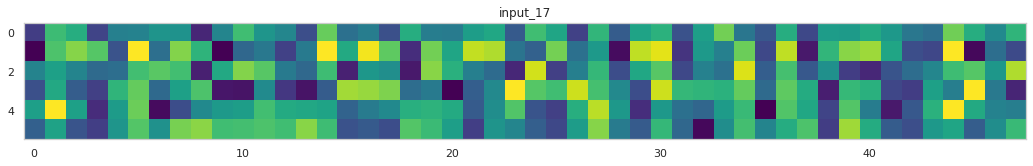

In [792]:
layer_names = []
for layer in model_test.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
layer_activation=weights[0]
first_layer_activation=layer_activation
images_per_row = 16
size = first_layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
scale=1./size
n_features = layer_activation.shape[-1] # Number of features in the feature map
n_cols = n_features // images_per_row # Tiles the activation channels in this matrix


display_grid = np.zeros((size * n_cols, images_per_row * size))

plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))

for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, # Displays the grid
                     row * size : (row + 1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.grid(False)
plt.title(layer_names[0])
plt.imshow(display_grid, aspect='auto', cmap='viridis')

# for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
#     n_features = layer_activation.shape[-1] # Number of features in the feature map
#     size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
#     n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
#     display_grid = np.zeros((size * n_cols, images_per_row * size))
#     for col in range(n_cols): # Tiles each filter into a big horizontal grid
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size, # Displays the grid
#                          row * size : (row + 1) * size] = channel_image
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)


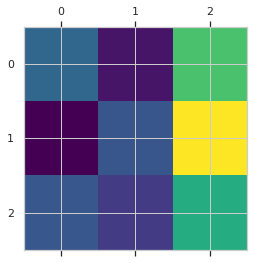

In [770]:

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')


In [ ]:
known = model_test.predict_generator(test_generator, verbose=1, workers=1, use_multiprocessing=False)

In [793]:
val_df.head()

,img_name,label,path
0,val_010323.jpg,247,input/val_set/val_010323.jpg
1,val_010324.jpg,234,input/val_set/val_010324.jpg
2,val_010325.jpg,222,input/val_set/val_010325.jpg
3,val_010326.jpg,240,input/val_set/val_010326.jpg
4,val_010327.jpg,218,input/val_set/val_010327.jpg


In [794]:
df_2 = val_df.sort_values('img_name')

In [795]:
df_2.head()

,img_name,label,path
1812,val_000000.jpg,142,input/val_set/val_000000.jpg
1813,val_000001.jpg,127,input/val_set/val_000001.jpg
1814,val_000002.jpg,129,input/val_set/val_000002.jpg
1815,val_000003.jpg,126,input/val_set/val_000003.jpg
1816,val_000004.jpg,209,input/val_set/val_000004.jpg


In [798]:
top_n = 1
df_sort=df_2
unmapped_preds = np.argsort(known, axis=1)[:,-top_n:]
# Try also commenting this out to see if we should use mapped or unmapped in our final results
key_list = list(test_generator.class_indices.keys())
val_list = list(test_generator.class_indices.values())
# These are from having an unsorted train list, not from validation. Nothing to do but map now.
df_sort['labelS']=0
top_n_mapped= unmapped_preds[:,-top_n:]
for i, j in enumerate(unmapped_preds):
    for k, l in enumerate(j):
        top_n_mapped[i,k]=int(key_list[val_list.index(l)])
        
df_sort['guess']=top_n_mapped[:,-1]

In [799]:
df_sort.head()

,img_name,label,path,labelS,guess
1812,val_000000.jpg,142,input/val_set/val_000000.jpg,0,142
1813,val_000001.jpg,127,input/val_set/val_000001.jpg,0,174
1814,val_000002.jpg,129,input/val_set/val_000002.jpg,0,129
1815,val_000003.jpg,126,input/val_set/val_000003.jpg,0,211
1816,val_000004.jpg,209,input/val_set/val_000004.jpg,0,209


In [803]:
y_test, y_pred = df_sort['label'], df_sort['guess']

In [806]:
y_test=y_test.astype(int)

Confusion matrix, without normalization
[[49  0  0 ...  0  0  0]
 [ 0 52  0 ...  0  0  0]
 [ 0  0 40 ...  0  0  0]
 ...
 [ 0  0  0 ... 30  0  0]
 [ 0  0  0 ...  0 34  0]
 [ 0  0  0 ...  0  0 42]]


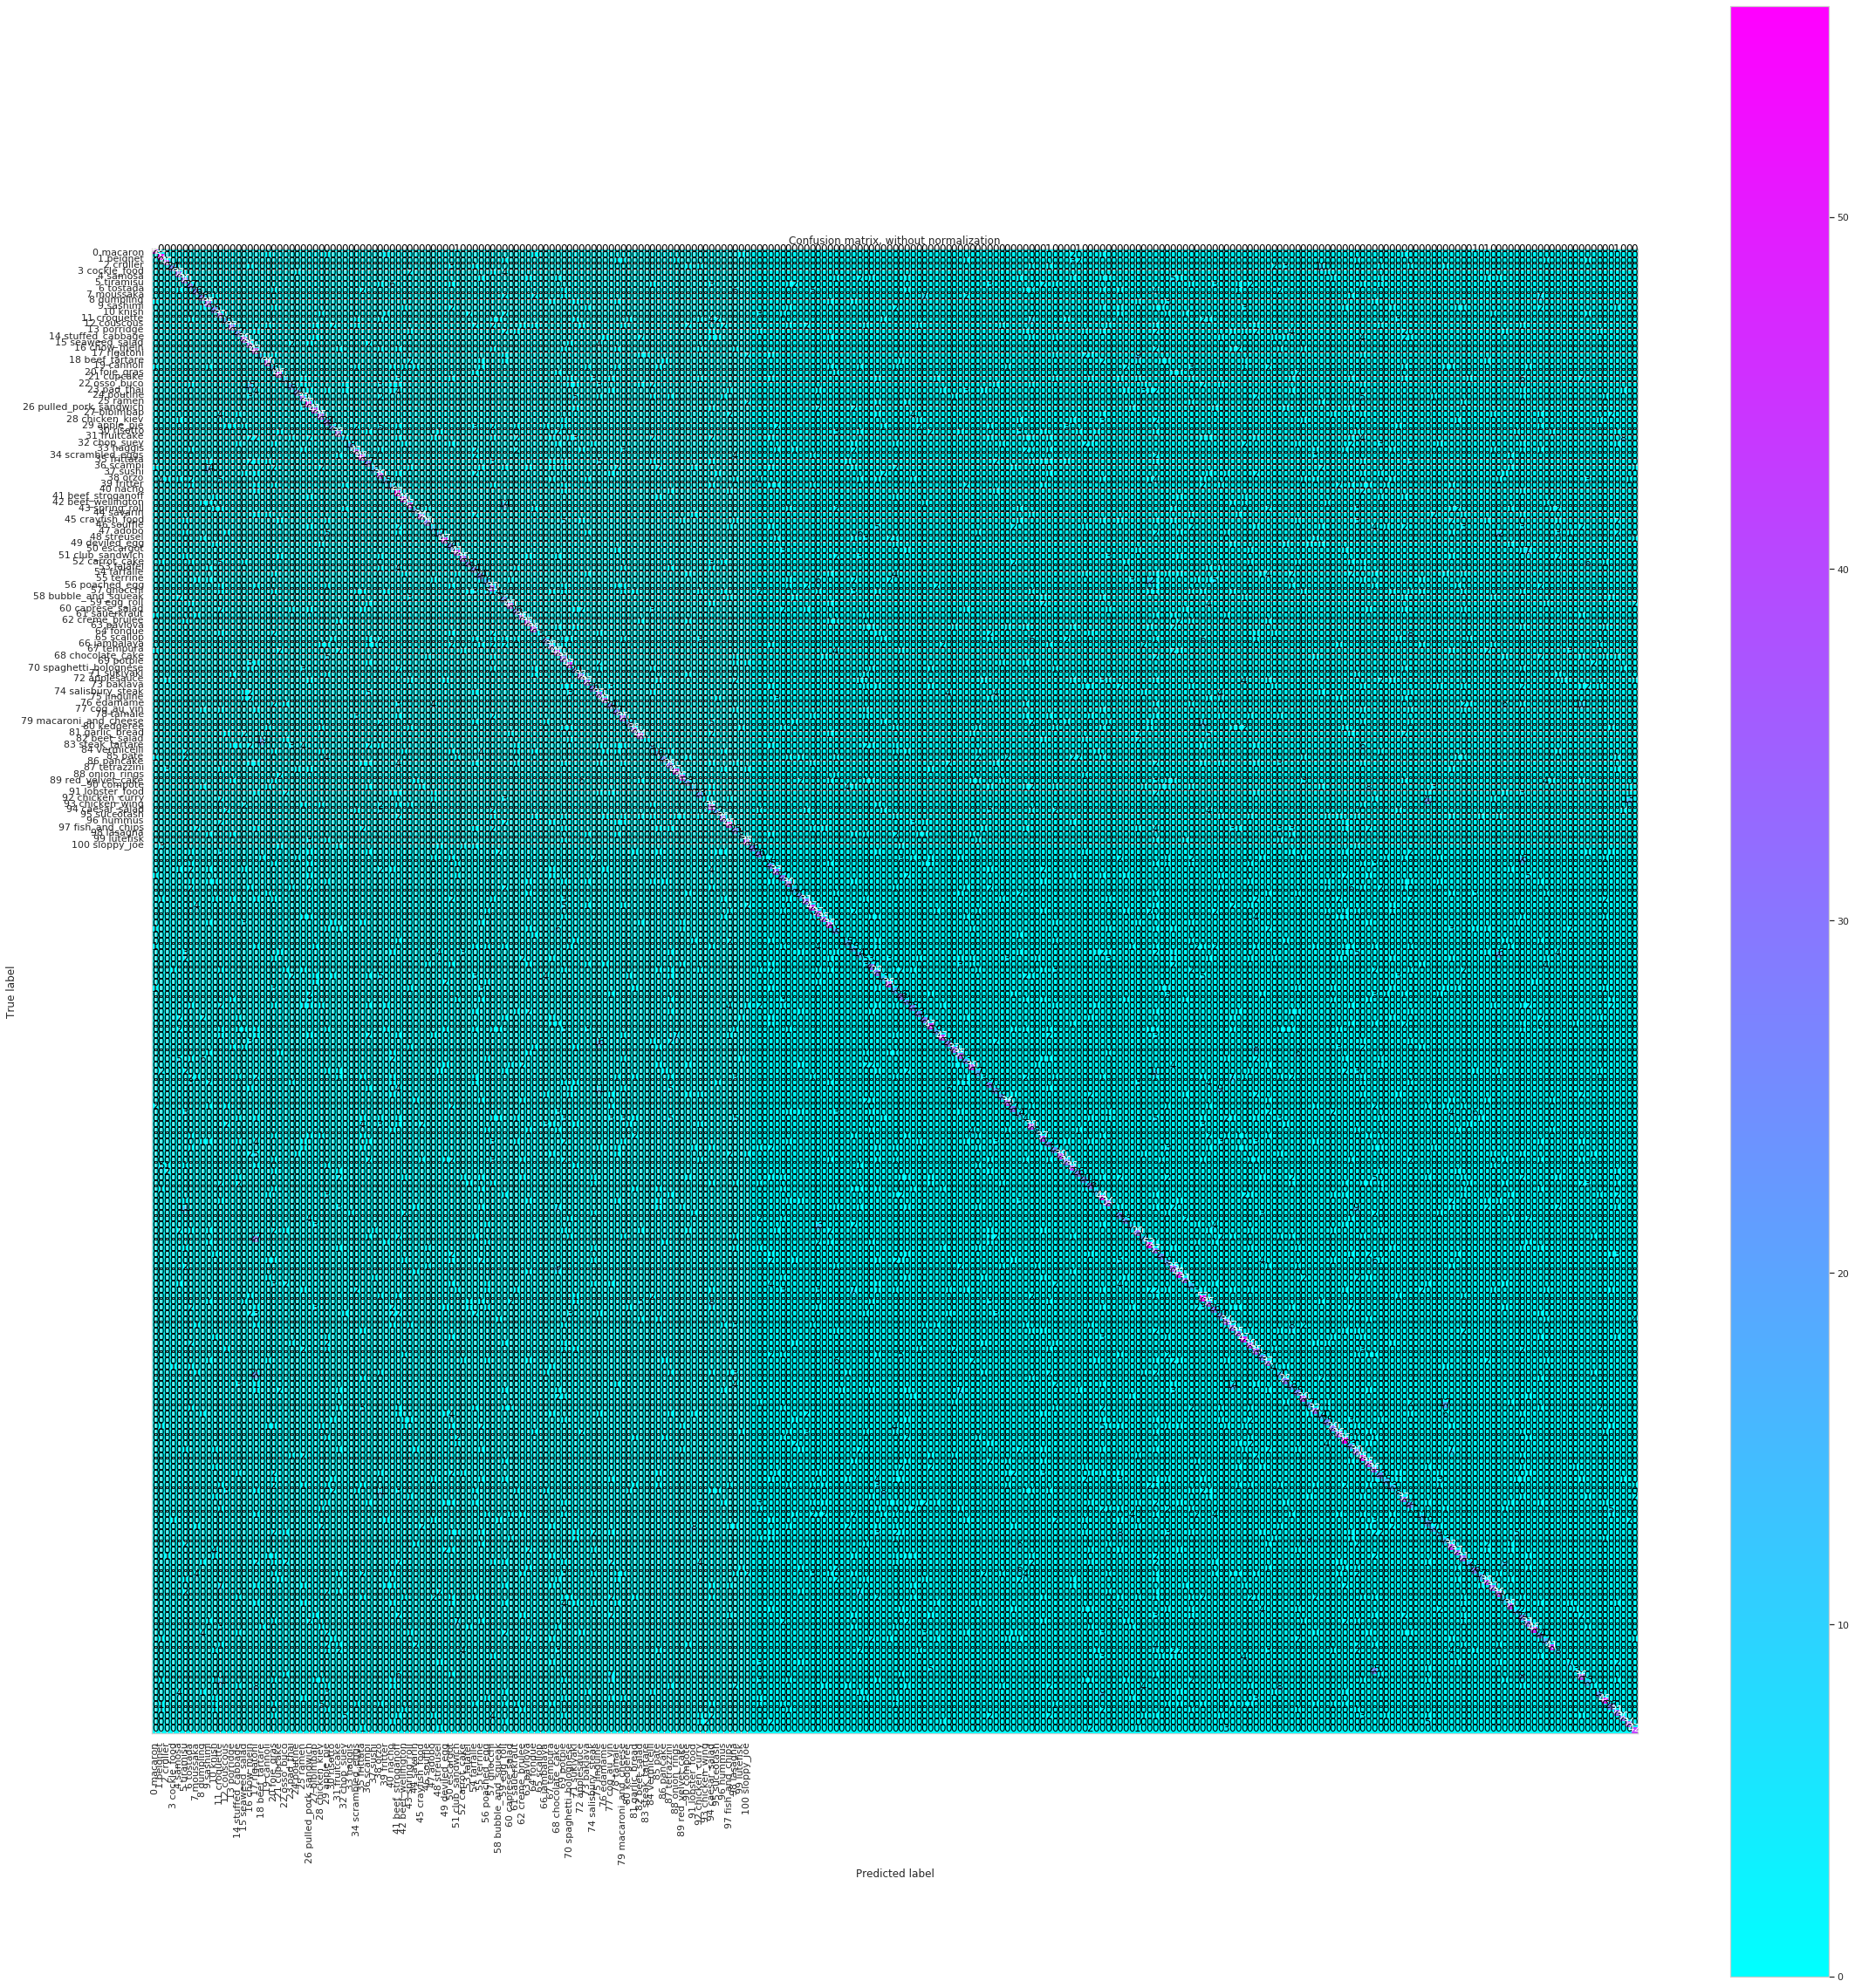

CPU times: user 2min 6s, sys: 15.1 s, total: 2min 22s
Wall time: 2min 9s


In [809]:
%%time
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = [ix_to_class[i] for i in range(101)]

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()

## Misc things (not useful really)

In [421]:
labels_to_classes = {v:k for k,v in test_generator.class_indices.items()}
assert df_2['label'].tolist()[:5] == [labels_to_classes[x] for x in test_generator.classes][:5]

In [437]:
key_list = list(test_generator.class_indices.keys())
val_list = list(test_generator.class_indices.values())

In [160]:
top_n=3
top_n_predscheck= np.argpartition(check, -top_n)[:,-top_n:]

In [41]:
df_train = pd.read_csv('./input/train_labels.csv')
df_test  = pd.read_csv('./input/val_labels.csv')

# convert class to string
# df_train['label'] = df_train['label'].astype(str)
# df_test['label'] = df_test['label'].astype(str)

# sample = 1000 
# df_train = df_train.sample(sample, random_state=22) 
# df_test  = df_test.sample(int(sample/5), random_state=22)

df_train.shape, df_test.shape

val_df['label']=val_df['label'].astype(str)
train_df['label']=train_df['label'].astype(str)

In [177]:
def load_img(path, target_mode=None, target_size=None):
    from PIL import Image
    img = Image.open(path)
    if target_mode:
        img = img.convert(target_mode)
    if target_size:
        img = img.resize((target_size[1], target_size[0]))
    return img


In [178]:
def pil_image_reader(filepath, target_mode=None, target_size=None, dim_ordering=K.image_data_format(), **kwargs):
    img = load_img(filepath, target_mode=target_mode, target_size=target_size)
    return img_to_array(img, dim_ordering=dim_ordering)

In [179]:
def img_to_array(img, dim_ordering=K.image_data_format()):
    if dim_ordering not in ['channels_first', 'channels_last']:
        raise Exception('Unknown dim_ordering: ', dim_ordering)
    # image has dim_ordering (height, width, channel)
    x = np.asarray(img, dtype='float32')
    if len(x.shape) == 3:
        if dim_ordering == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if dim_ordering == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise Exception('Unsupported image shape: ', x.shape)
    return x

In [303]:
def read_images(path_to_data, img_name, target_size=(256,256), answers=True, val=True, train=False):
    path = path_to_data + img_name
    x = pil_image_reader(path, target_size=target_size)
    x = x/255.
    if answers:
        if val:
            y = int(val_df[val_df['img_name']==img_name]['label'])
        if train:
            y = int(train_df[train_df['img_name']==img_name]['label'])
        return x, y
    else:
        return x

In [307]:
sampler = 100
top_n = 10
X = np.ndarray(shape=(sampler,256,256,3))
Y = np.zeros(sampler)


for j in range(0,100):
    right_counter = 0.0
    for i in range(0,sampler):
        h=i+(j*sampler)
        x, y = read_images(train_dir, train_df.iloc[h]['img_name'], target_size=(256,256), val=False, train=True)
        X[i]=x
        Y[i]=y
    pred = model_test.predict(X)
    y_pred = np.argsort(pred, axis=1)[:,-top_n:]

    for i in range(sampler):
        guesses, actual = y_pred[i], Y[i]
        if actual in guesses:
            right_counter += 1.0
    print(right_counter)

5.0
10.0
5.0
4.0
2.0
6.0


KeyboardInterrupt: 